# COMP 579 Assignment 1

Deadline: Thursday, January 25th, 2024

Author:
* Ali Karami: ali.karami@mcgill.ca


In [8]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import math


plt.rcParams["figure.figsize"]=10,5

## Q1 Simulator for Bernoulli Bandit

In [27]:
class BernoulliBandit:
  """
  A class for Bernoulli multi-armed bandit.

  Attributes
  ----------
  num_arms : int
      The number of arms in the bernoulli bandit
  probs_fct : callable(time_step)
      function defining the probability of drawing 1 for each arm indexed from 0 as a function of time steps

  Methods
  -------
  sample(arm_index)
      Returns a reward sample of the binomial distribution indexed by the arm_index (return 0 with probability
      1-probs_arr[k] and 1 with probability probs_arr[k])
  """

  def __init__(self, num_arms, probs_fct):
    self.num_arms = num_arms
    self.probs_fct = probs_fct

  def sample(self, arm_index, time_step = 0):
    # if no time step is given, use time step 0 since the probability function is constant
    return 0 if random.random() < 1 - self.probs_fct(time_step)[arm_index] else 1

In [28]:
delta = 0.1
num_arms = 3
probs_arr = [0.5+delta, 0.5, 0.5-delta]

# define probability function as a function of t for each arm
def probs_fct(t):
  return probs_arr

num_samples = 50

three_arm_bernoulli_bandit = BernoulliBandit(num_arms, probs_fct)
actions = range(num_arms)

action_rewards = []
for action in actions:
  # store 50 samples per action
  rewards = [three_arm_bernoulli_bandit.sample(action) for _ in range(num_samples)]
  action_rewards.append(rewards)

### Graphs

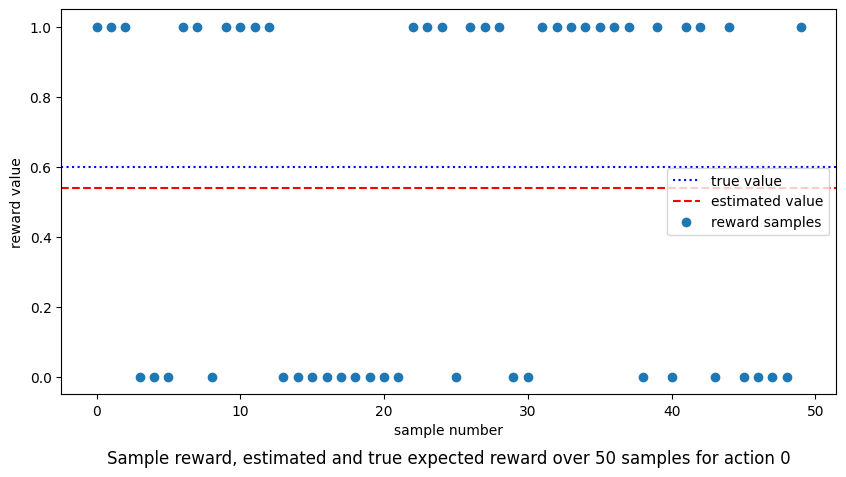

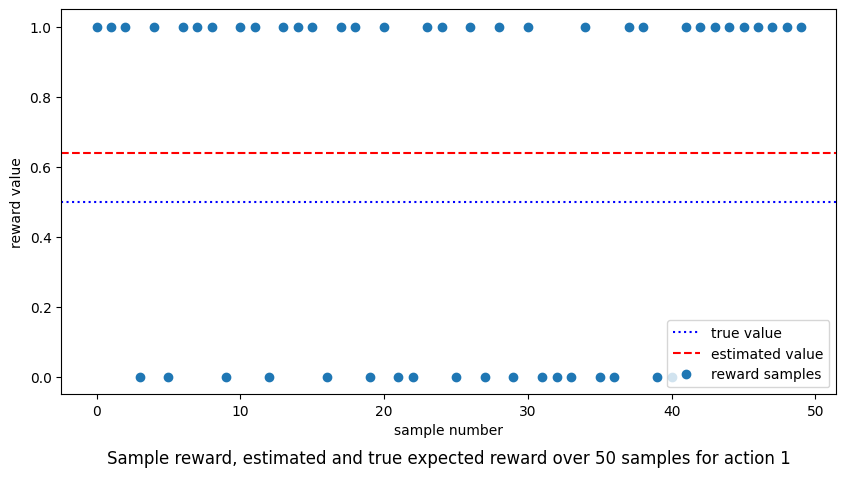

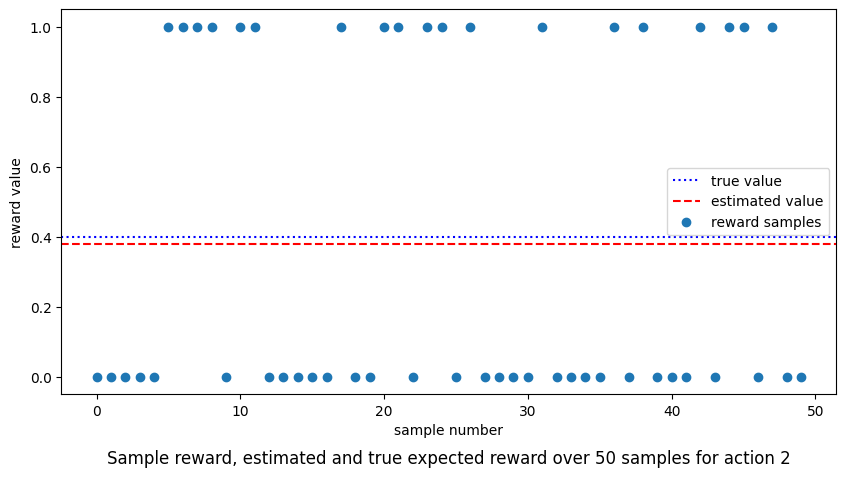

In [29]:
for action in actions:
  fig, ax = plt.subplots()

  true_value = probs_arr[action]
  estimated_value = np.mean(np.array(action_rewards[action]))
  # draw the line of the true value
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")
  # draw the line of the estimated value
  line_est_val = ax.axhline(y = estimated_value, color = 'r', linestyle = '--', label = "estimated value")
  # plot the reward samples
  plt_samples, = ax.plot(action_rewards[action], 'o', label = "reward samples")

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Sample reward, estimated and true expected reward over 50 samples for action %s" %action, y=-0.2)

  # show the legend with the labels of the line
  ax.legend(handles=[line_true_val, line_est_val, plt_samples])

## Q2 Estimated Q values

In [30]:
def update(reward_samples, alpha):
  """
  Each call to the function yields the current incremental average of the reward with a fixed learning rate, alpha
  E.g. Inital call returns alpha * reward_samples[0], second call returns prev_val + alpha * (reward_samples[1] - prev_val)
  where prev_val is the value return from the previous call, so on and so forth

  Parameters
  ----------
  reward_samples : array of int
      samples of reward values from one arm of a bandit
  alpha : int
      learning rate parameter for the averaging
  """
  prev_val = 0
  for sample in reward_samples:
    new_val = alpha * sample + (1 - alpha) * prev_val
    prev_val = new_val
    yield new_val

def updateAvg(reward_samples):
  """
  Each call to the function yields the current incremental average of the reward
  E.g. Inital call returns reward_samples[0], second call returns the average of reward_samples[0] and reward_samples[0], so on and so forth

  Parameters
  ----------
  reward_samples : array of int
      samples of reward values from one arm of a bandit
  """
  prev_val = reward_samples[0]
  n = 1
  # first iteration only updates n to 2, no update to average
  for sample in reward_samples:
    new_val = prev_val + (sample - prev_val) / n
    prev_val = new_val
    n = n + 1
    yield new_val

### Graphs

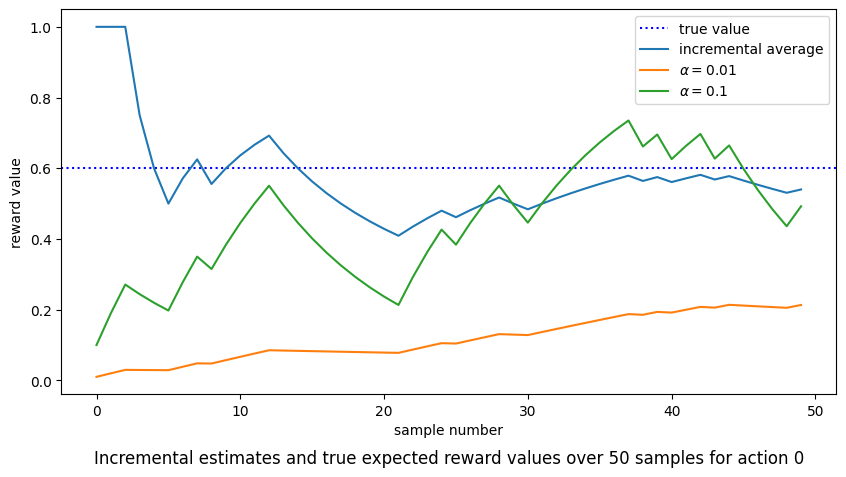

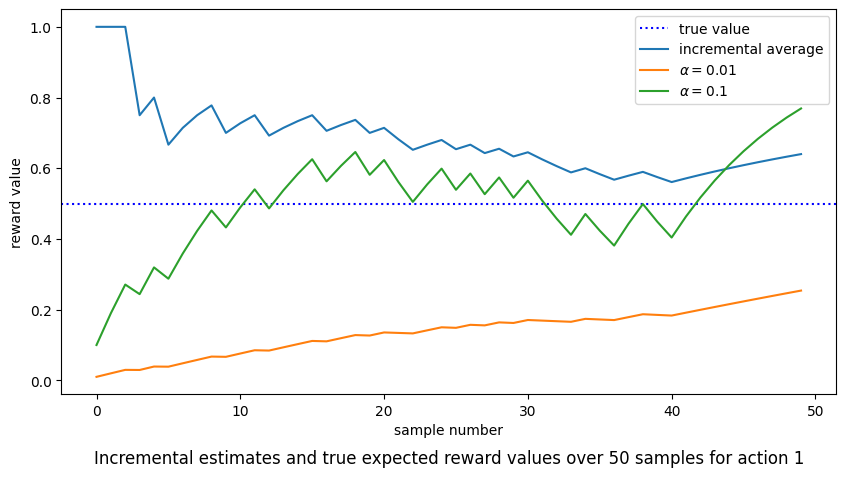

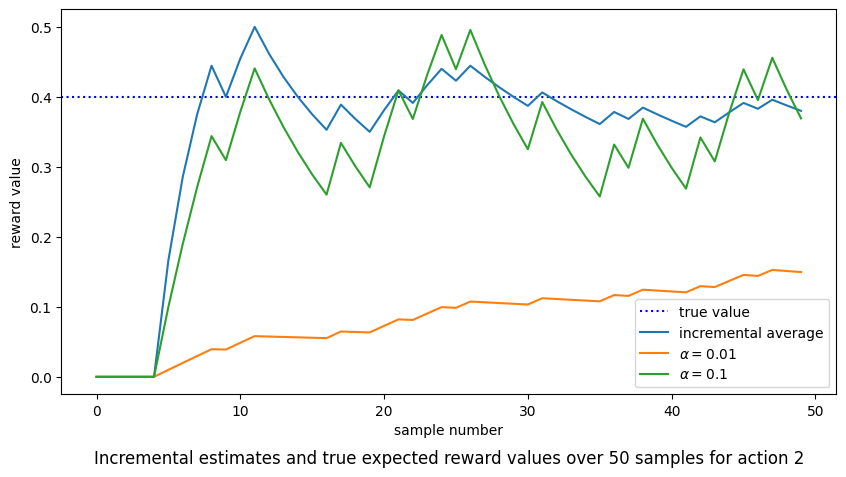

In [31]:
for action in actions:
  fig, ax = plt.subplots()

  # obtain incremental values for averaging, alpha = 0.01, alpha = 0.1
  # incr_avgs_gen = updateAvg(action_rewards[action])
  # alpha_1_percent_gen = update(action_rewards[action], 0.01)
  # alpha_10_percent_gen = update(action_rewards[action], 0.1)

  incr_avgs = list(updateAvg(action_rewards[action]))
  alpha_1_percent = list(update(action_rewards[action], 0.01))
  alpha_10_percent = list(update(action_rewards[action], 0.1))
  true_value = probs_arr[action]
  # draw the true value line
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")

  # plot incremental values for averaging, alpha = 0.01, alpha = 0.1
  plt_incr_avgs, = ax.plot(incr_avgs, label = "incremental average")
  plt_alpha_1_percent, = ax.plot(alpha_1_percent, label = r"$\alpha = 0.01$")
  plt_alpha_10_percent, = ax.plot(alpha_10_percent, label = r"$\alpha = 0.1$")

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Incremental estimates and true expected reward values over 50 samples for action %s" %action, y=-0.2)

  # show the legend with the labels of the line
  ax.legend(handles=[line_true_val, plt_incr_avgs, plt_alpha_1_percent, plt_alpha_10_percent])

## Q3 Effect of $α$ on Estimated Q values

In [32]:
num_samples = 100

# arrays of the data generated from 100 runs
incr_avgs_runs = []
alpha_1_percent_runs = []
alpha_10_percent_runs = []

for run in range(100):
  # arrays of data generated from the 3 actions in 1 run
  sample_incr_avgs_by_actions = []
  sample_alpha_1_percent_by_actions = []
  sample_alpha_10_percent_by_actions = []

  for action in actions:
    rewards = [three_arm_bernoulli_bandit.sample(action) for _ in range(num_samples)]

    sample_incr_avgs_by_actions.append(list(updateAvg(rewards)))
    sample_alpha_1_percent_by_actions.append(list(update(rewards, 0.01)))
    sample_alpha_10_percent_by_actions.append(list(update(rewards, 0.1)))

  incr_avgs_runs.append(sample_incr_avgs_by_actions)
  alpha_1_percent_runs.append(sample_alpha_1_percent_by_actions)
  alpha_10_percent_runs.append(sample_alpha_10_percent_by_actions)

# convert to np arrays
incr_avgs_runs = np.asarray(incr_avgs_runs)
alpha_1_percent_runs = np.asarray(alpha_1_percent_runs)
alpha_10_percent_runs = np.asarray(alpha_10_percent_runs)

### Graphs

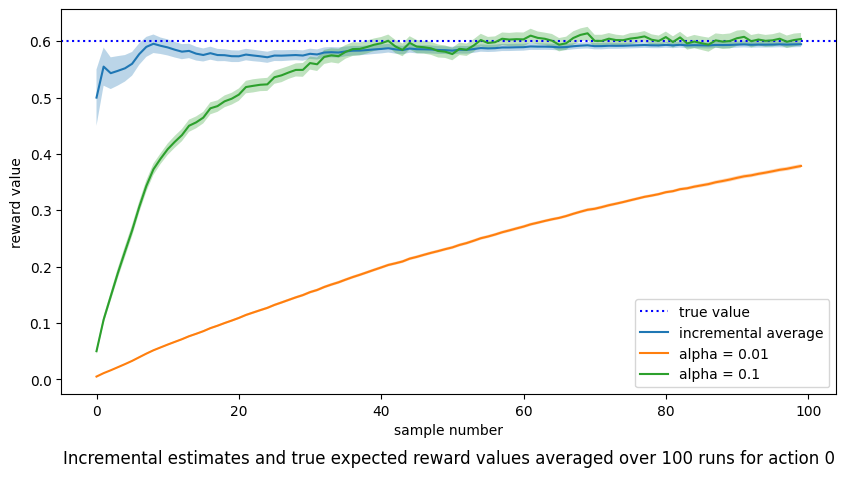

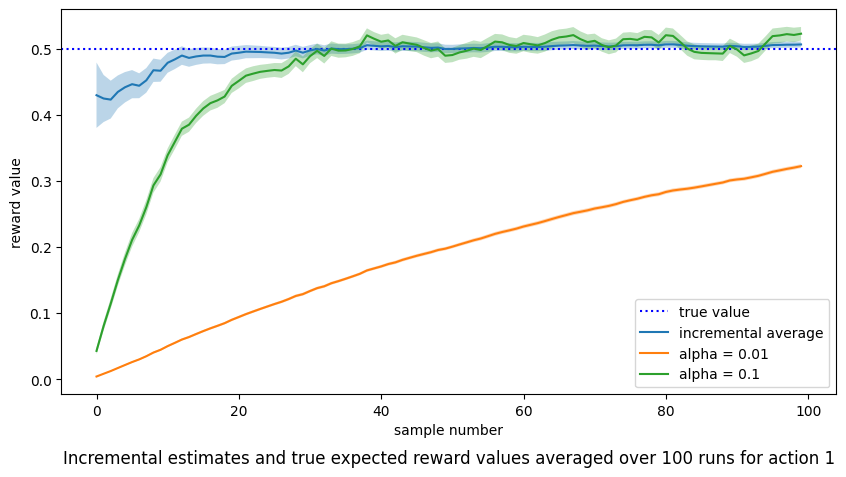

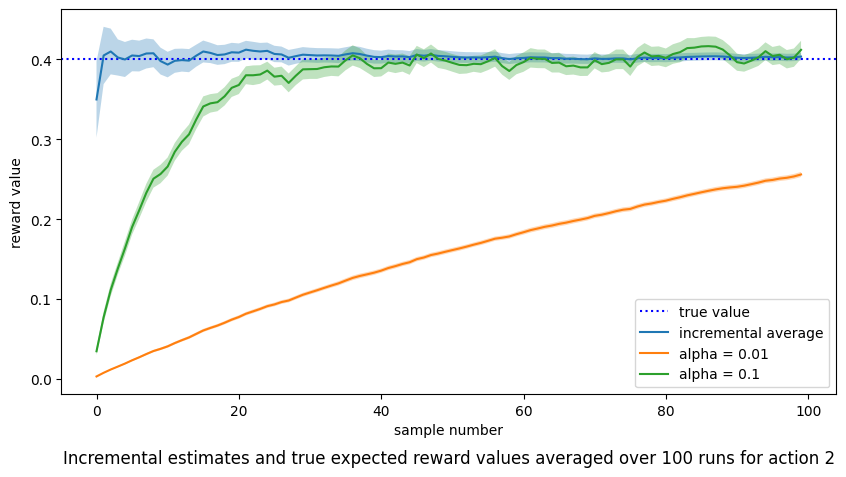

In [33]:
for action in actions:
  fig, ax = plt.subplots()

  # obtain averaged incremental reward values for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  mean_incr_avgs_by_actions = np.mean(incr_avgs_runs[:,action,:], axis=0)
  mean_alpha_1_percent_by_actions = np.mean(alpha_1_percent_runs[:,action,:], axis=0)
  mean_alpha_10_percent_by_actions = np.mean(alpha_10_percent_runs[:,action,:], axis=0)
  true_value = probs_arr[action]

  # obtain the standard deviation for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  std_incr_avgs_by_actions = np.std(incr_avgs_runs[:,action,:], axis=0)
  std_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:,action,:], axis=0)
  std_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:,action,:], axis=0)

  # obtain the standard error for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  std_err_incr_avgs_by_actions = np.std(incr_avgs_runs[:,action,:], axis=0) / np.sqrt(np.size(incr_avgs_runs[:,action,:], axis=0))
  std_err_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:,action,:], axis=0) / np.sqrt(np.size(alpha_1_percent_runs[:,action,:], axis=0))
  std_err_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:,action,:], axis=0) / np.sqrt(np.size(alpha_10_percent_runs[:,action,:], axis=0))

  # draw the true value line
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")

  # draw the averaged incremental reward values for averaging
  plt_incr_avgs, = ax.plot(mean_incr_avgs_by_actions, label = "incremental average")
  # draw the error bar/area for averaging
  incr_avgs_minus_std_err = mean_incr_avgs_by_actions - std_err_incr_avgs_by_actions
  incr_avgs_plus_std_err = mean_incr_avgs_by_actions + std_err_incr_avgs_by_actions
  ax.fill_between(range(0,100), incr_avgs_minus_std_err, incr_avgs_plus_std_err, alpha=0.3)

  # draw the averaged incremental reward values for alpha = 0.01
  plt_alpha_1_percent, = ax.plot(mean_alpha_1_percent_by_actions, label = "alpha = 0.01")
  # draw the error bar/area for alpha = 0.01
  alpha_1_percent_minus_std_err = mean_alpha_1_percent_by_actions - std_err_alpha_1_percent_by_actions
  alpha_1_percent_plus_std_err = mean_alpha_1_percent_by_actions + std_err_alpha_1_percent_by_actions
  ax.fill_between(range(0,100), alpha_1_percent_minus_std_err, alpha_1_percent_plus_std_err, alpha=0.3)

  # draw the averaged incremental reward values for alpha = 0.1
  plt_alpha_10_percent, = ax.plot(mean_alpha_10_percent_by_actions, label = "alpha = 0.1")
  # draw the error bar/area for alpha = 0.1
  alpha_10_percent_minus_std_err = mean_alpha_10_percent_by_actions - std_err_alpha_10_percent_by_actions
  alpha_10_percent_plus_std_err = mean_alpha_10_percent_by_actions + std_err_alpha_10_percent_by_actions
  ax.fill_between(range(0,100), alpha_10_percent_minus_std_err, alpha_10_percent_plus_std_err, alpha=0.3)

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Incremental estimates and true expected reward values averaged over 100 runs for action %s" %action, y=-0.2)

  ax.legend(handles=[line_true_val, plt_incr_avgs, plt_alpha_1_percent, plt_alpha_10_percent])

### Answers
#### Explain in 1-2 sentences what you observe.
The incremental average method starts off a lot closer to the true value and seems to settle to the true value. The 0.1 alpha gets to the true value quicker than the 0.01 alpha but has more variation in the line.
#### Which of the α values is better? How do they compare to averaging? If you wanted to optimize further, in what range of α would you look for better values?
The 0.1 alpha is better for doing 100 samples but if you were to take more samples, the 0.01 would be more stable once it reaches the true value. I would therefore look for an alpha in between to attempt to get it to converge faster but also remain more stable around the true value with lower variance.

## Q4 Epsilon-greedy

In [43]:
def epsilon_greedy(bandit, epsilon, alpha = None, num_time_step = 1000):
  """Epsilon greedy algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample
  epsilon: float
      A parameter which determines the probability for a random action to be selected
  alpha: (optional) float
      A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
      Default is none, corresponding to incremental averaging.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """

  num_arms = bandit.num_arms

  Q_arr = np.zeros(num_arms) # array of estimated average reward for each action
  N_arr = np.zeros(num_arms) # array of number of times picked for each action
  total_R = 0
  total_l = 0
  actions = range(num_arms)
  
  opt_value = lambda t: max(bandit.probs_fct(t))               # highest expected reward among all actions
  best_action = lambda t: bandit.probs_fct(t).index(opt_value(t)) # the index of the action with highest expected reward

  R_over_t = []
  total_R_over_t = []
  est_is_best_over_t = []
  l_over_t = []
  total_l_over_t = []

  for time_step in range(num_time_step):
    A_star = np.random.choice(np.where(Q_arr == max(Q_arr))[0])     # get action with highest estimated average reward with random tie-breaking
    A_random = np.random.choice(actions)       # pick a random action
    A = np.random.choice([A_random, A_star], p=[epsilon, 1-epsilon]) # pick a random action with probability epsilon
    curr_R = bandit.sample(A, time_step)
    N_arr[A] = N_arr[A] + 1
    if alpha == None:
      # incremental averaging
      Q_arr[A] = Q_arr[A] + (curr_R - Q_arr[A]) / N_arr[A]
    else:
      Q_arr[A] = Q_arr[A] + alpha * (curr_R - Q_arr[A])

    R_over_t.append(curr_R)

    total_R = total_R + curr_R
    total_R_over_t.append(total_R)

    est_is_best = 1 if A == best_action(time_step) else 0
    est_is_best_over_t.append(est_is_best)

    l_t = opt_value(time_step) - curr_R
    l_over_t.append(l_t)

    total_l = total_l + l_t
    total_l_over_t.append(total_l)

  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

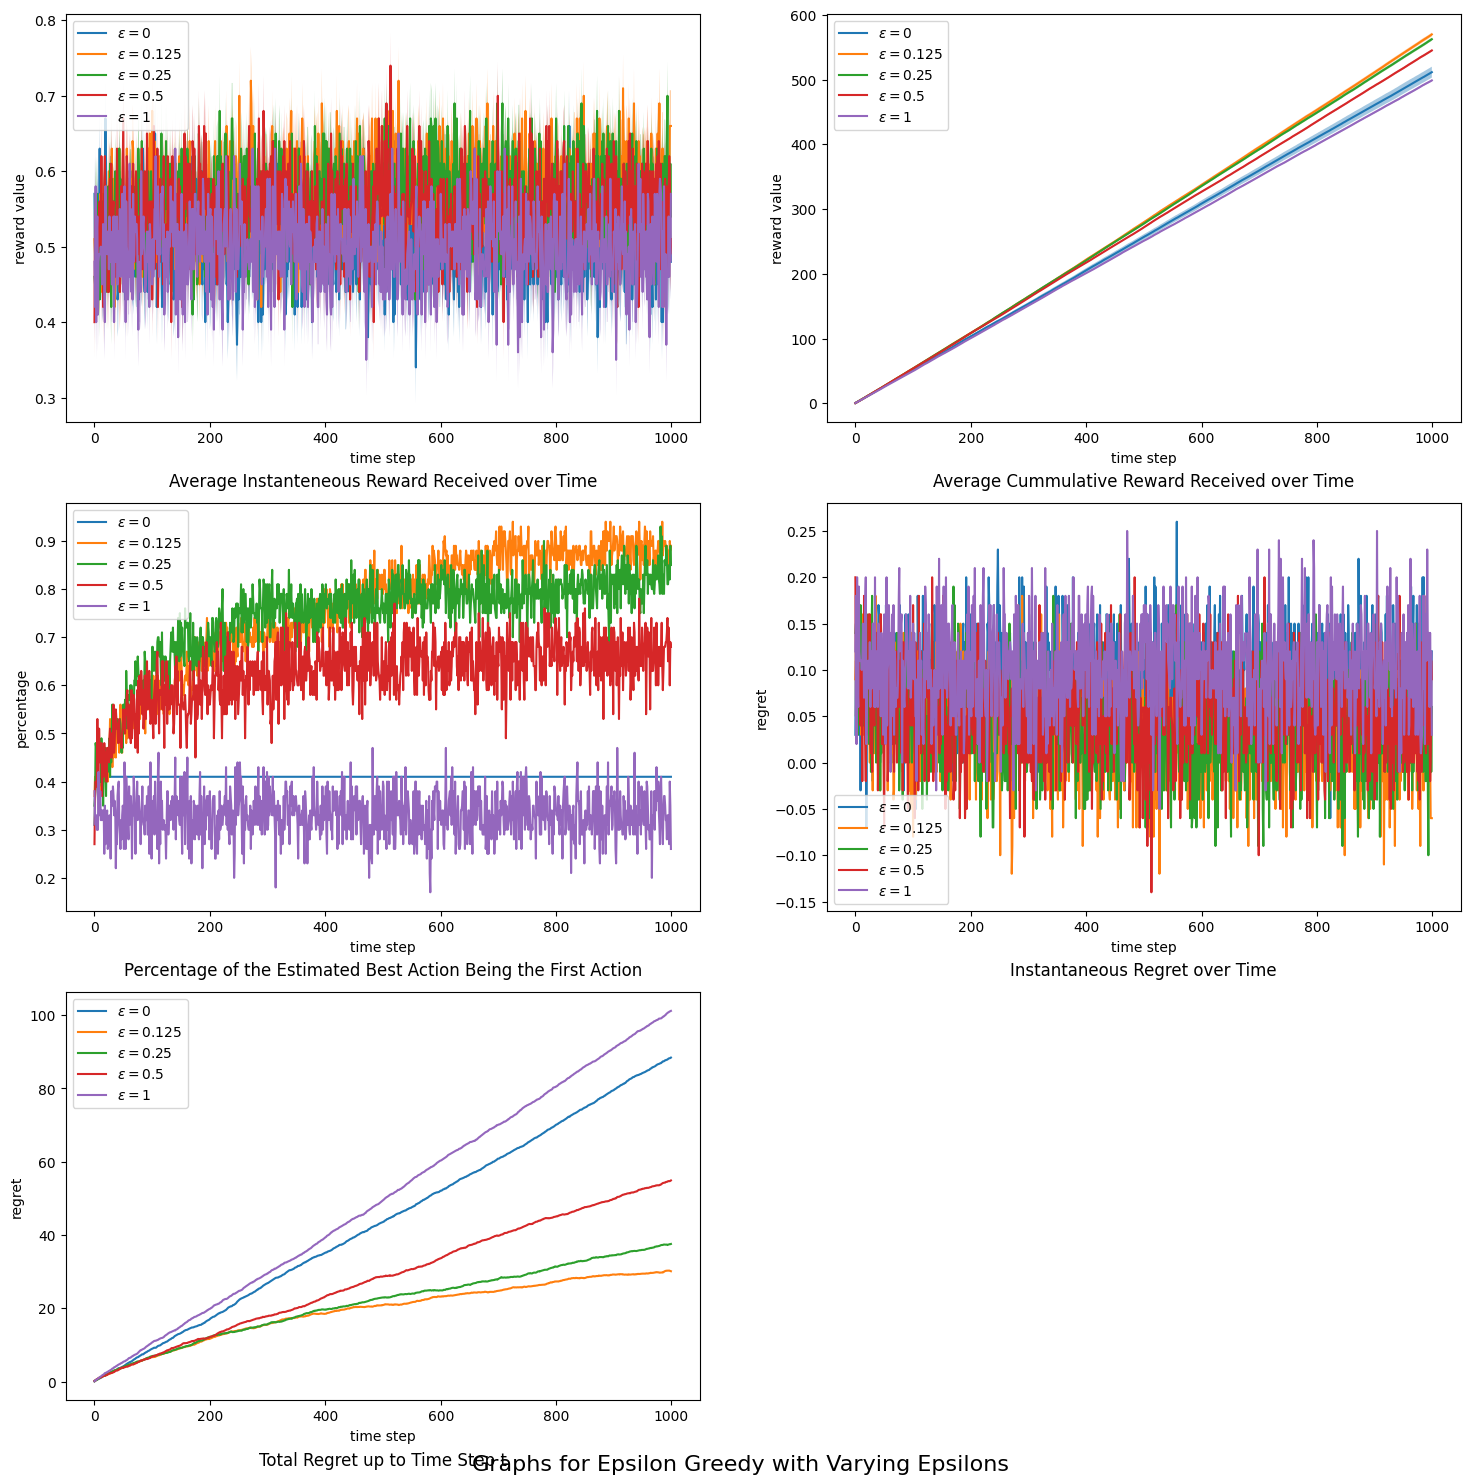

In [44]:
epsilons = [0, 1/8, 1/4, 1/2, 1]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for epsilon in epsilons:

  # arrays of the data generated from 100 runs
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time
  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)
  
  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r'Graphs for Epsilon Greedy with Varying Epsilons'
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

Your answers goes here ...

##Q5 Hyperparameters for Epsilon-greedy

To have a plain start, you have been provided with predefined functions for generating plots until now. However, moving forward, you are expected to plot graphs on your own.

### Graphs

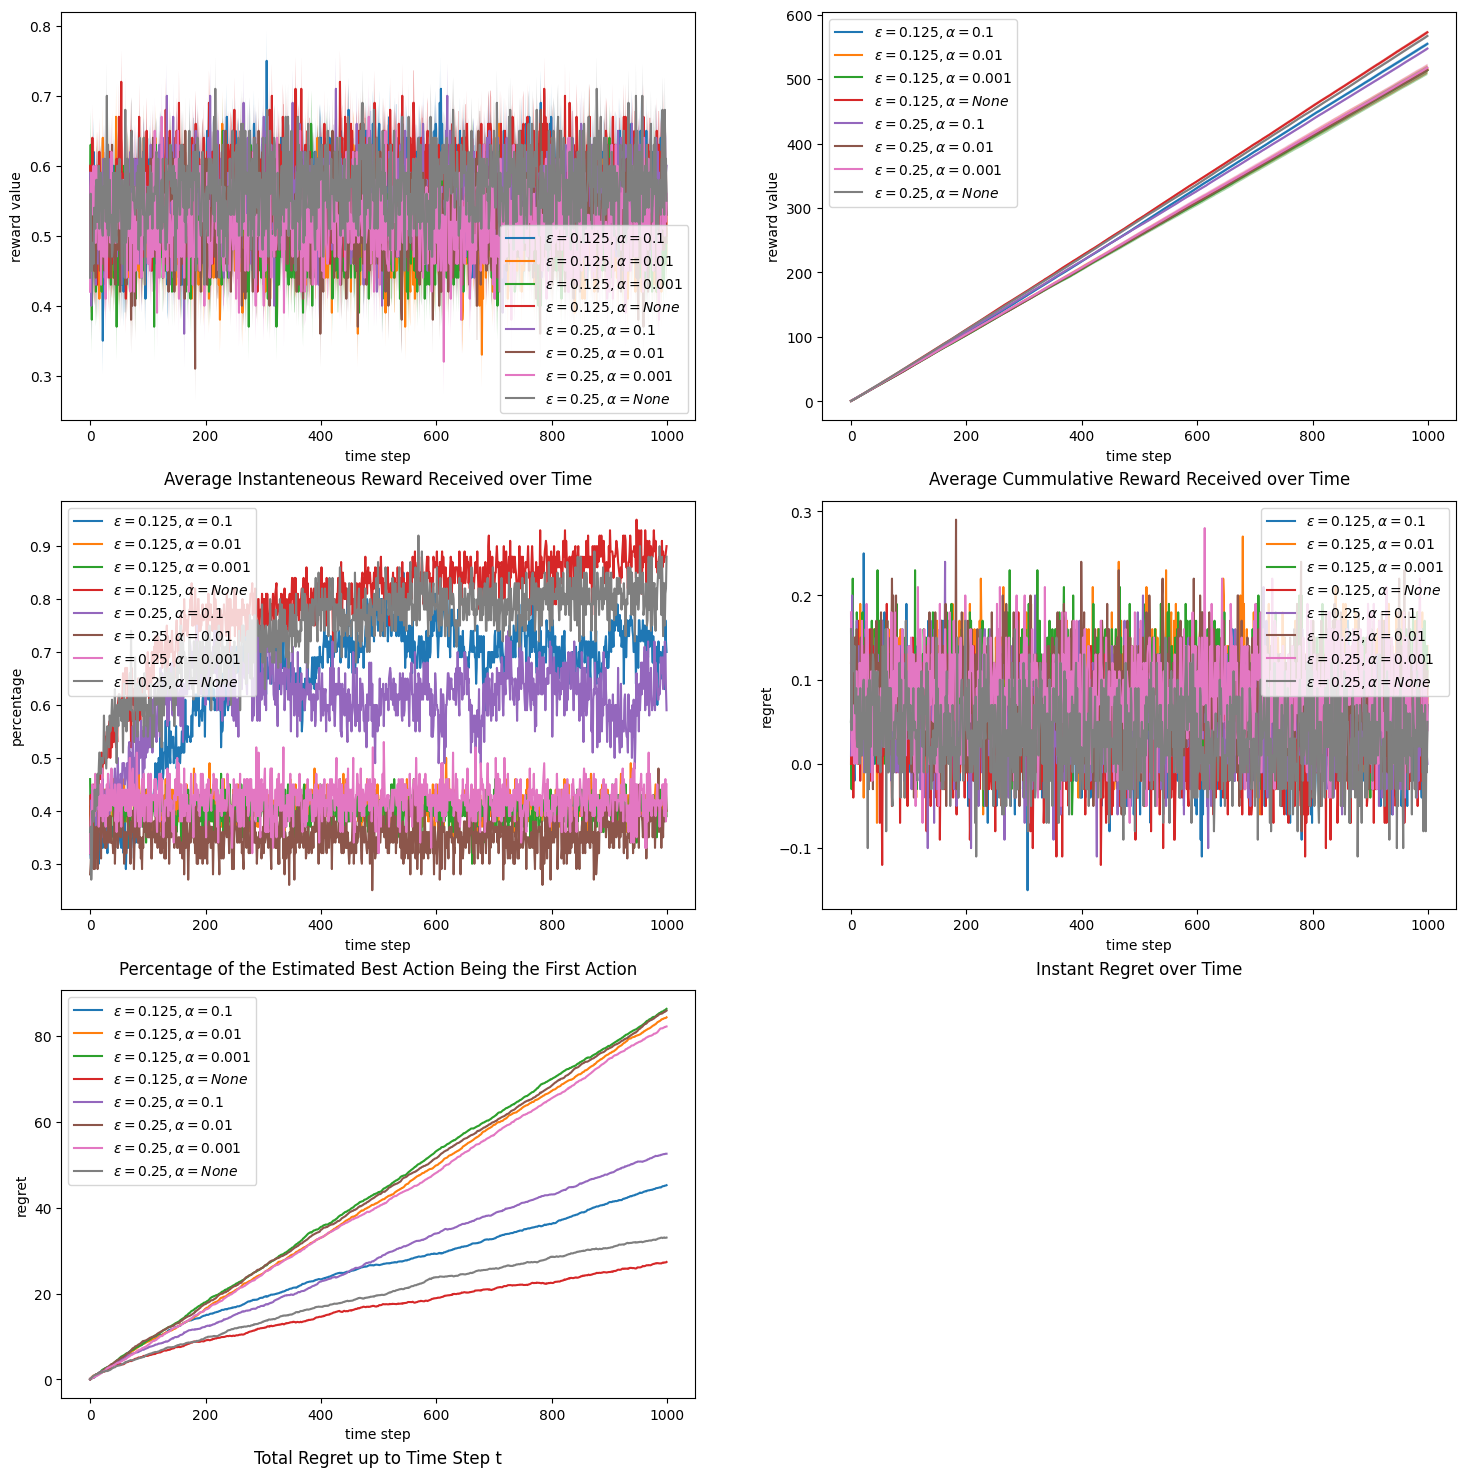

In [45]:
#For ε = 1/4 and ε = 1/8, plot the same graphs for α = 0.1, α = 0.01, α = 0.001 and averaging. Explain in 2 sentences what you observe
epsilons = [1/8, 1/4]
alphas = [0.1, 0.01, 0.001, None]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
for epsilon in epsilons:
    for alpha in alphas:
        # arrays of the data generated from 100 runs
        R_over_t_runs = []
        total_R_over_t_runs = []
        est_is_best_over_t_runs = []
        l_over_t_runs = []
        total_l_over_t_runs = []

        for run in range(100):
            R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon, alpha)

            R_over_t_runs.append(R_over_t)
            total_R_over_t_runs.append(total_R_over_t)
            est_is_best_over_t_runs.append(est_is_best_over_t)
            l_over_t_runs.append(l_over_t)
            total_l_over_t_runs.append(total_l_over_t)

        R_over_t_runs = np.asarray(R_over_t_runs)
        total_R_over_t_runs = np.asarray(total_R_over_t_runs)
        est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
        l_over_t_runs = np.asarray(l_over_t_runs)
        total_l_over_t_runs = np.asarray(total_l_over_t_runs)

        # plot the mean reward over time
        mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
        std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

        axs[0,0].plot(mean_R_over_t_runs, label = r"$\epsilon = %s, \alpha = %s$" %(epsilon, alpha))

        R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
        R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
        axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
        # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

        axs[0,0].legend()
        axs[0,0].set_xlabel("time step")
        axs[0,0].set_ylabel("reward value")
        axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

        # plot the mean cummulative reward over time
        
        mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
        std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

        axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\epsilon = %s, \alpha = %s$" %(epsilon, alpha))

        total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
        total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
        axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

        axs[0,1].legend()
        axs[0,1].set_xlabel("time step")
        axs[0,1].set_ylabel("reward value")
        axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

        #plot the mean percentage of the estimated best action being the first action

        est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
        plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\epsilon = %s, \alpha = %s$" %(epsilon, alpha))

        axs[1,0].legend()
        axs[1,0].set_xlabel("time step")
        axs[1,0].set_ylabel("percentage")
        axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

        #plot the mean instantaneous regret over time

        l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
        axs[1,1].plot(l_over_t_runs_avgs, label = r"$\epsilon = %s, \alpha = %s$" %(epsilon, alpha))

        axs[1,1].legend()
        axs[1,1].set_xlabel("time step")
        axs[1,1].set_ylabel("regret")
        axs[1,1].set_title("Instant Regret over Time", y=-0.18)

        #plot the total regret over time

        total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
        axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\epsilon = %s, \alpha = %s$" %(epsilon, alpha))

        axs[2,0].legend()
        axs[2,0].set_xlabel("time step")
        axs[2,0].set_ylabel("regret")
        axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

plt.show()

### Answers

Your answers goes here ...

## Q6 UCB

In [46]:
def UCB(bandit, c = 2, alpha = None, num_time_step = 1000):
    """Upper confidence bound algorithm for bandit action selection

    Parameters
    ----------
    bandit : bandit class
        A bernoulli bandit attributes num_arms and probs_arr, and method sample
    c: int
        A parameter which determines the degree of exploration, the higher the c the higher the tendency for
        the algorithm to explore potentially suboptimal actionss
    alpha: (optional) float
        A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
        Default is none, corresponding to incremental averaging.

    Returns
    -------
    R_over_t
        a list of instantaneous return over the time steps
    total_R_over_t
        a list of cummulative reward over the time steps
    est_is_best_over_t
        a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
    l_over_t
        a list of instanteneous regret over the time steps
    total_l_over_t
        a list of cummulative regret over the time steps
    """
    num_arms = bandit.num_arms
    Q_arr = np.zeros(num_arms) # array of estimated average reward for each action
    N_arr = np.zeros(num_arms) # array of number of times picked for each action
    total_R = 0
    total_l = 0
    actions = range(num_arms)

    opt_value = lambda t: max(bandit.probs_fct(t))               # highest expected reward among all actions
    best_action = lambda t: bandit.probs_fct(t).index(opt_value(t)) # the index of the action with highest expected reward
    
    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []

    #try each action once
    for action in actions:
        curr_R = bandit.sample(action)
        N_arr[action] = N_arr[action] + 1
        if alpha == None:
            # incremental averaging
            Q_arr[action] = Q_arr[action] + (curr_R - Q_arr[action]) / N_arr[action]
        else:
            Q_arr[action] = Q_arr[action] + alpha * (curr_R - Q_arr[action])

        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        est_is_best = 1 if action == best_action(0) else 0
        est_is_best_over_t.append(est_is_best)

        l_t = opt_value(0) - curr_R
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)

    for time_step in range(num_time_step-len(actions)):
        vals = Q_arr + c * np.sqrt(np.log(time_step + 1) /N_arr)
        A = np.random.choice(np.where(vals == max(vals))[0])     # get action with highest estimated average reward with random tie-breaking
        curr_R = bandit.sample(A, time_step)
        N_arr[A] = N_arr[A] + 1
        if alpha == None:
            # incremental averaging
            Q_arr[A] = Q_arr[A] + (curr_R - Q_arr[A]) / N_arr[A]
        else:
            Q_arr[A] = Q_arr[A] + alpha * (curr_R - Q_arr[A])
        
        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        est_is_best = 1 if A == best_action(time_step) else 0
        est_is_best_over_t.append(est_is_best)

        l_t = opt_value(time_step) - curr_R
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)

    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

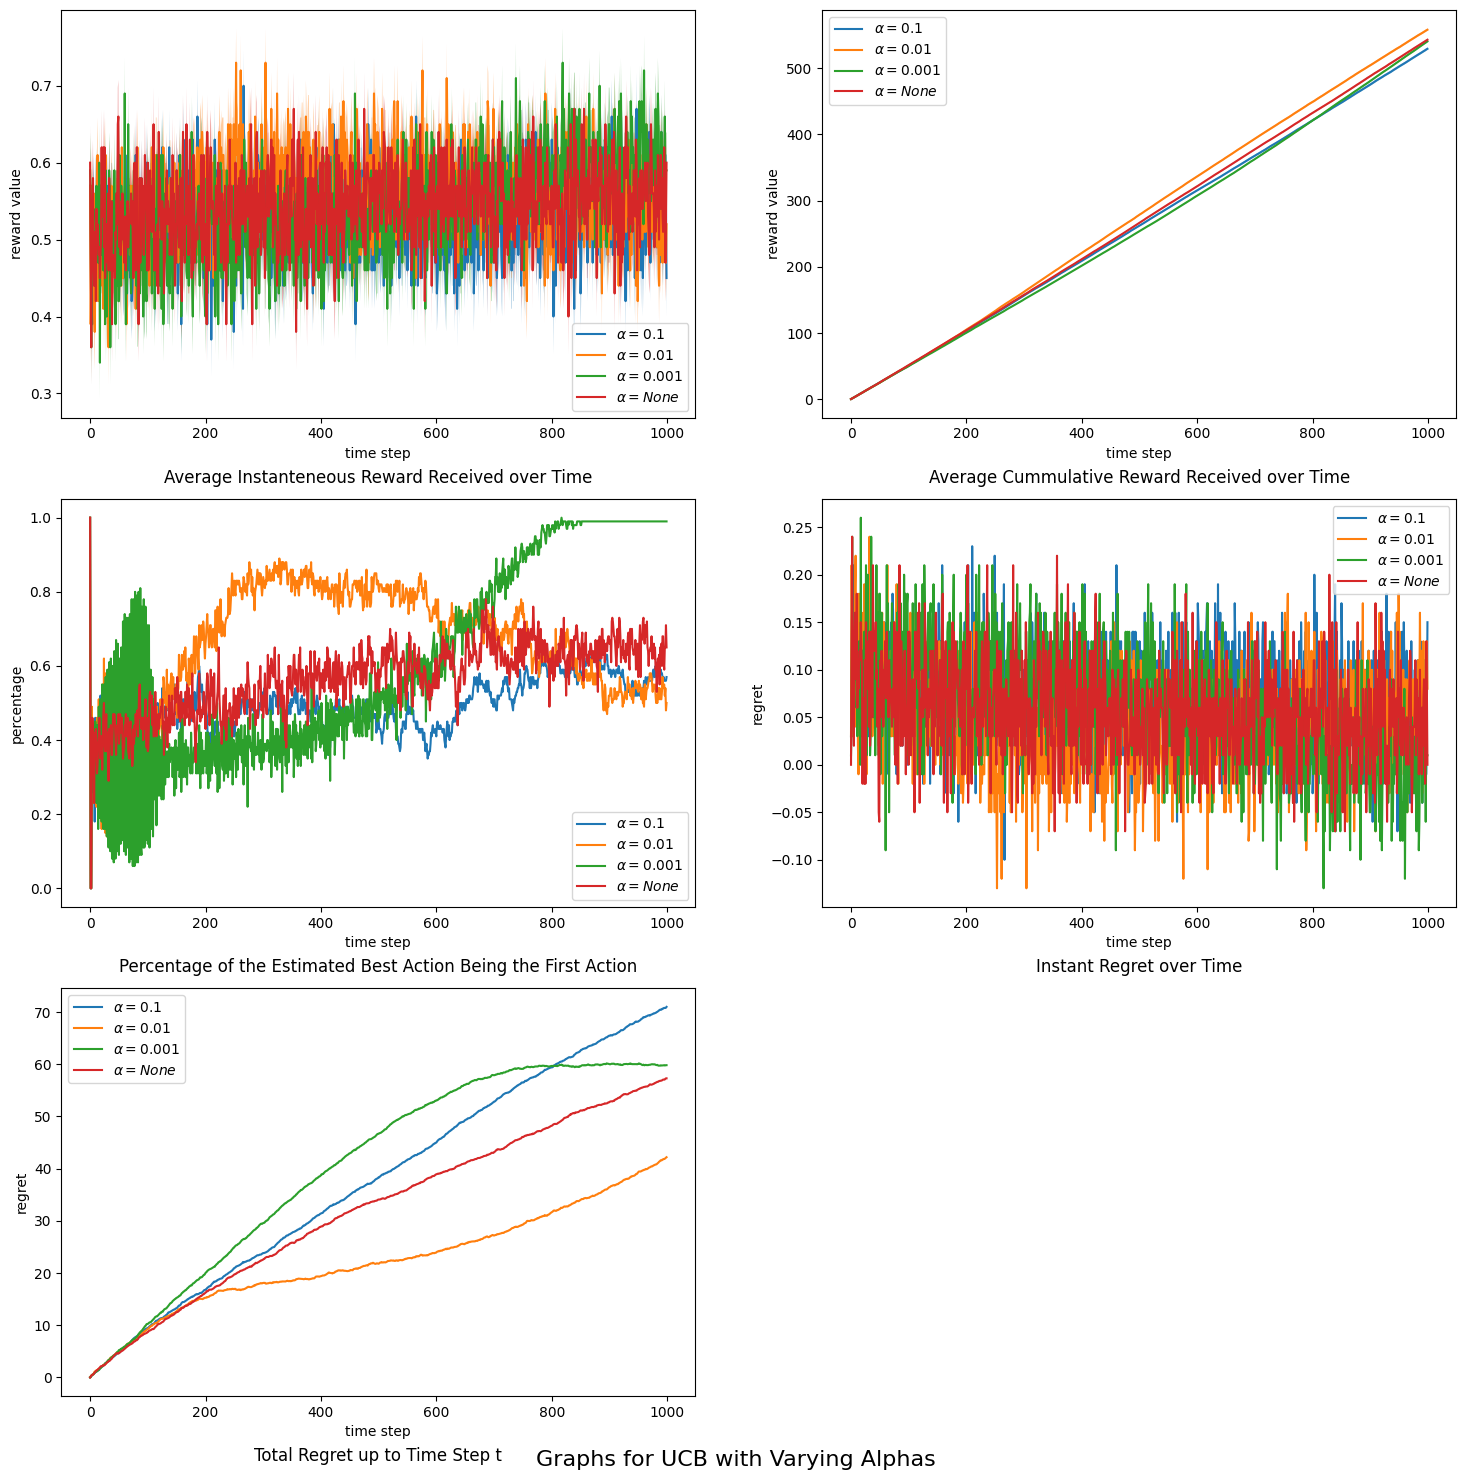

In [47]:
# α = 0.1, α = 0.01, α = 0.001 and averaging
alphas = [0.1, 0.01, 0.001, None]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for alpha in alphas:

    # arrays of the data generated from 100 runs
    R_over_t_runs = []
    total_R_over_t_runs = []
    est_is_best_over_t_runs = []
    l_over_t_runs = []
    total_l_over_t_runs = []

    for run in range(100):
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = UCB(three_arm_bernoulli_bandit, alpha=alpha)

        R_over_t_runs.append(R_over_t)
        total_R_over_t_runs.append(total_R_over_t)
        est_is_best_over_t_runs.append(est_is_best_over_t)
        l_over_t_runs.append(l_over_t)
        total_l_over_t_runs.append(total_l_over_t)

    R_over_t_runs = np.asarray(R_over_t_runs)
    total_R_over_t_runs = np.asarray(total_R_over_t_runs)
    est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
    l_over_t_runs = np.asarray(l_over_t_runs)
    total_l_over_t_runs = np.asarray(total_l_over_t_runs)

    # plot the mean reward over time
    mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
    std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

    axs[0,0].plot(mean_R_over_t_runs, label = r"$\alpha = %s$" %alpha)

    R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
    R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
    axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
    # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

    axs[0,0].legend()
    axs[0,0].set_xlabel("time step")
    axs[0,0].set_ylabel("reward value")
    axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

    # plot the mean cummulative reward

    mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
    std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

    axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\alpha = %s$" %alpha)

    total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
    total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
    axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

    axs[0,1].legend()
    axs[0,1].set_xlabel("time step")
    axs[0,1].set_ylabel("reward value")
    axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

    #plot the mean percentage of the estimated best action being the first action

    est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
    plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha)

    axs[1,0].legend()
    axs[1,0].set_xlabel("time step")
    axs[1,0].set_ylabel("percentage")
    axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

    #plot the mean instantaneous regret over time

    l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
    axs[1,1].plot(l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha)

    axs[1,1].legend()
    axs[1,1].set_xlabel("time step")
    axs[1,1].set_ylabel("regret")
    axs[1,1].set_title("Instant Regret over Time", y=-0.18)

    #plot the total regret over time

    total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
    axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha)

    axs[2,0].legend()
    axs[2,0].set_xlabel("time step")
    axs[2,0].set_ylabel("regret")
    axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r'Graphs for UCB with Varying Alphas'
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

Your answers goes here ...


## Q7 Thompson Sampling

In [48]:
def Thompson_sampling(bandit, num_time_step = 1000):
    """Thompson sampling algorithm for bandit action selection

    Parameters
    ----------
    bandit : bandit class
        A bernoulli bandit attributes num_arms and probs_arr, and method sample

    Returns
    -------
    R_over_t
        a list of instantaneous return over the time steps
    total_R_over_t
        a list of cummulative reward over the time steps
    est_is_best_over_t
        a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
    l_over_t
        a list of instanteneous regret over the time steps
    total_l_over_t
        a list of cummulative regret over the time steps
    """

    num_arms = bandit.num_arms
    Q_arr = np.zeros(num_arms) # array of estimated average reward for each action
    N_arr = np.zeros(num_arms) # array of number of times picked for each action
    total_R = 0
    total_l = 0

    opt_value = lambda t: max(bandit.probs_fct(t))               # highest expected reward among all actions
    best_action = lambda t: bandit.probs_fct(t).index(opt_value(t)) # the index of the action with highest expected reward
    
    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []

    for time_step in range(num_time_step):
        vals = np.random.beta(Q_arr + 1, N_arr - Q_arr + 1)
        A = np.random.choice(np.where(vals == max(vals))[0])     # get action with highest estimated average reward with random tie-breaking
        curr_R = bandit.sample(A, time_step)
        N_arr[A] = N_arr[A] + 1
        Q_arr[A] = Q_arr[A] + (curr_R - Q_arr[A]) / N_arr[A]
        
        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        est_is_best = 1 if A == best_action(time_step) else 0
        est_is_best_over_t.append(est_is_best)

        l_t = opt_value(time_step) - curr_R
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)

    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

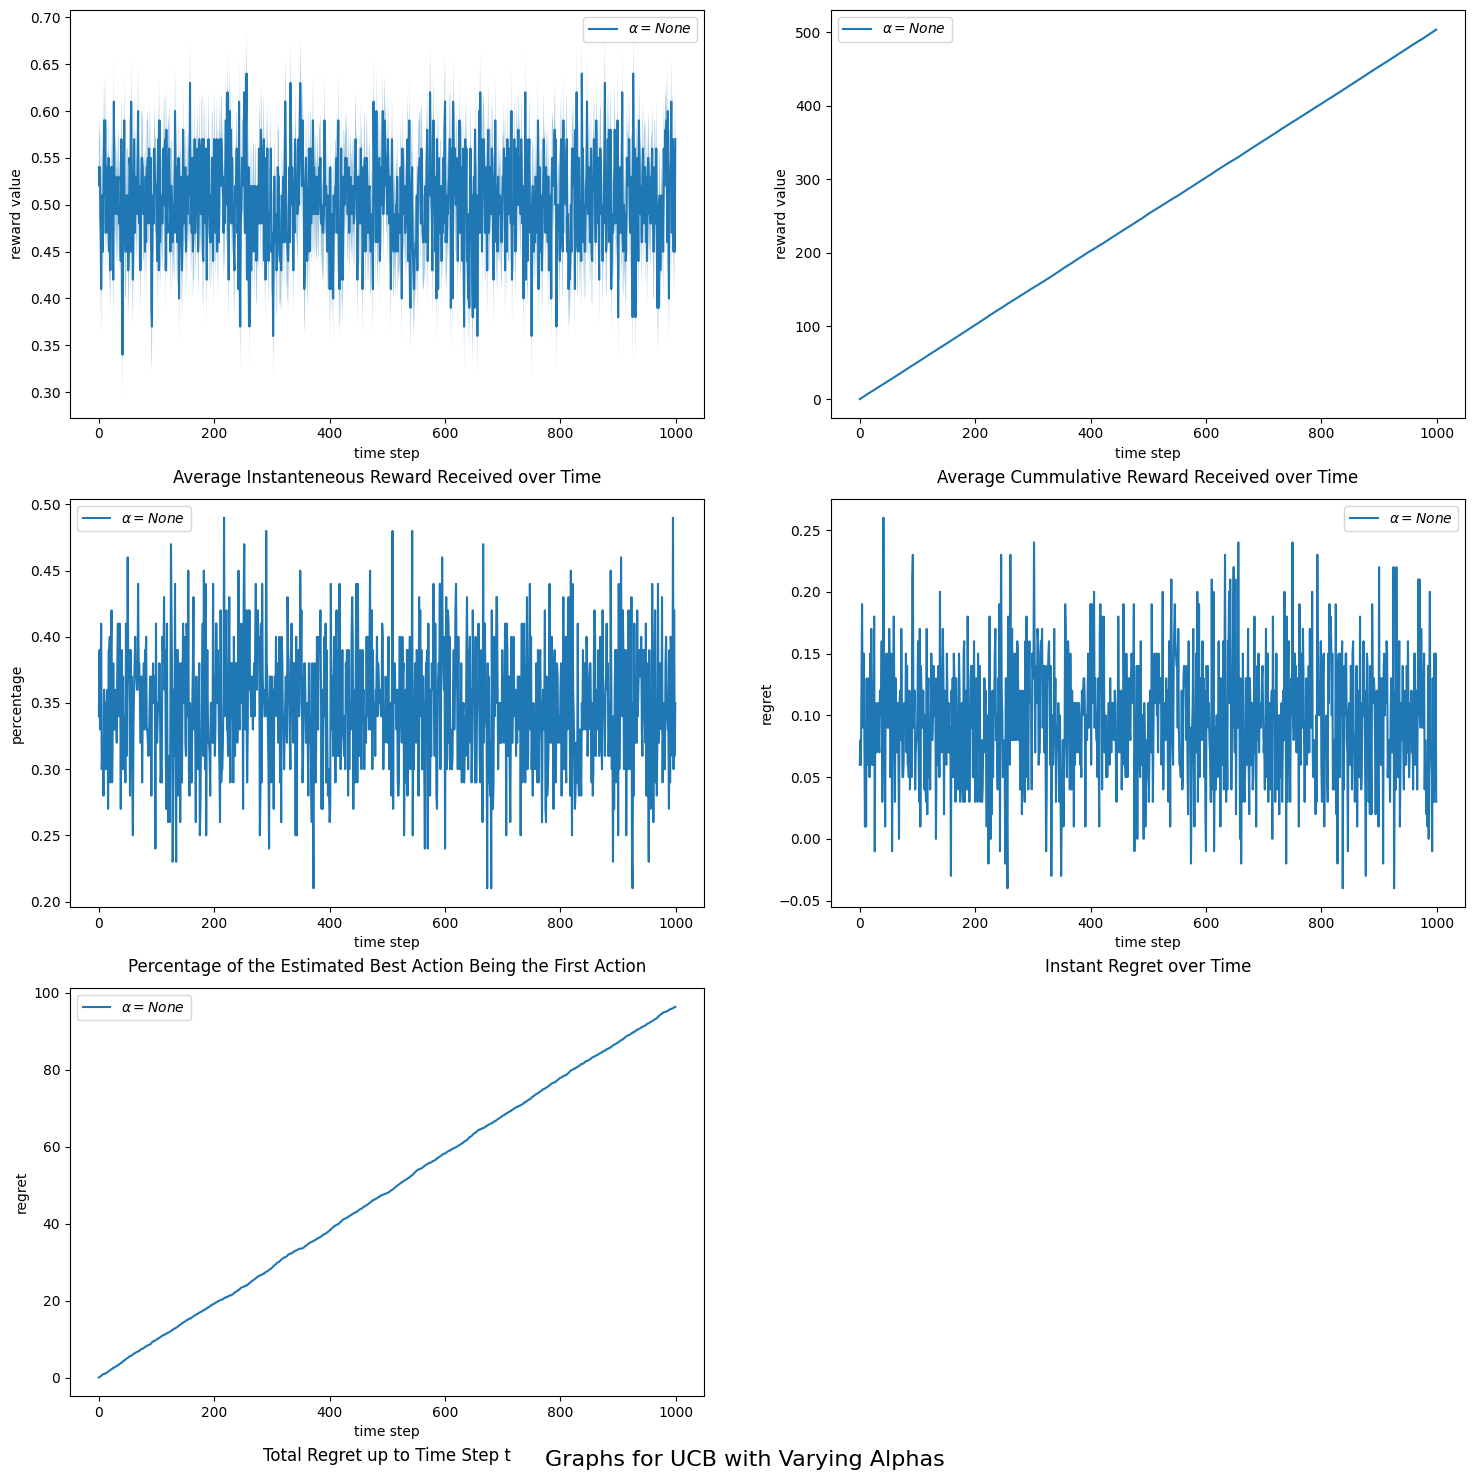

In [49]:
# α = 0.1, α = 0.01, α = 0.001 and averaging
alphas = [None]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for alpha in alphas:

    # arrays of the data generated from 100 runs
    R_over_t_runs = []
    total_R_over_t_runs = []
    est_is_best_over_t_runs = []
    l_over_t_runs = []
    total_l_over_t_runs = []

    for run in range(100):
        R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = Thompson_sampling(three_arm_bernoulli_bandit)

        R_over_t_runs.append(R_over_t)
        total_R_over_t_runs.append(total_R_over_t)
        est_is_best_over_t_runs.append(est_is_best_over_t)
        l_over_t_runs.append(l_over_t)
        total_l_over_t_runs.append(total_l_over_t)

    R_over_t_runs = np.asarray(R_over_t_runs)
    total_R_over_t_runs = np.asarray(total_R_over_t_runs)
    est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
    l_over_t_runs = np.asarray(l_over_t_runs)
    total_l_over_t_runs = np.asarray(total_l_over_t_runs)

    # plot the mean reward over time
    mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
    std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

    axs[0,0].plot(mean_R_over_t_runs, label = r"$\alpha = %s$" %alpha)

    R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
    R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
    axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
    # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

    axs[0,0].legend()
    axs[0,0].set_xlabel("time step")
    axs[0,0].set_ylabel("reward value")
    axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

    # plot the mean cummulative reward

    mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
    std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

    axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\alpha = %s$" %alpha)

    total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
    total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
    axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

    axs[0,1].legend()
    axs[0,1].set_xlabel("time step")
    axs[0,1].set_ylabel("reward value")
    axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

    #plot the mean percentage of the estimated best action being the first action

    est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
    plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha)

    axs[1,0].legend()
    axs[1,0].set_xlabel("time step")
    axs[1,0].set_ylabel("percentage")
    axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

    #plot the mean instantaneous regret over time

    l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
    axs[1,1].plot(l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha)

    axs[1,1].legend()
    axs[1,1].set_xlabel("time step")
    axs[1,1].set_ylabel("regret")
    axs[1,1].set_title("Instant Regret over Time", y=-0.18)

    #plot the total regret over time

    total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
    axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha)

    axs[2,0].legend()
    axs[2,0].set_xlabel("time step")
    axs[2,0].set_ylabel("regret")
    axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r'Graphs for UCB with Varying Alphas'
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

Your answers goes here ...

## Q8 Comparison of Algorithms

### Graphs

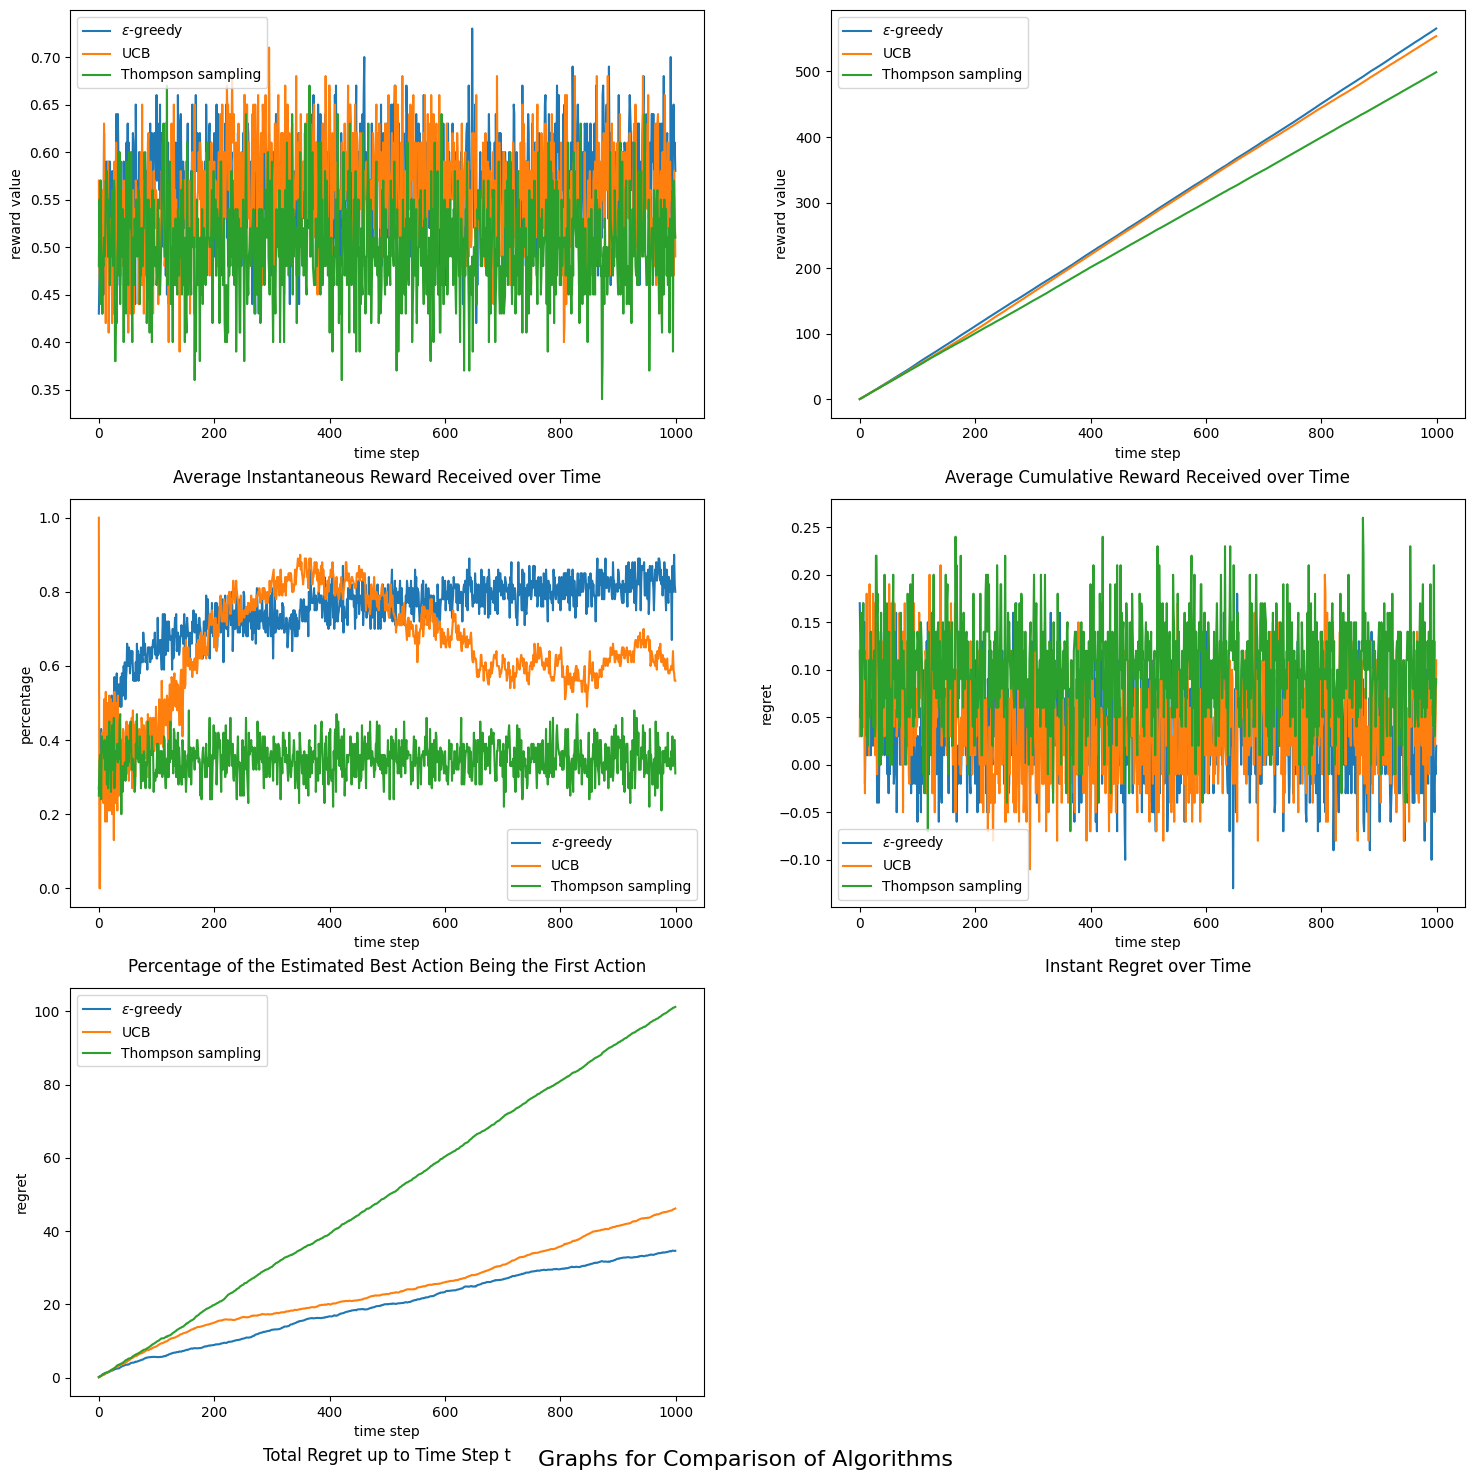

In [50]:
"""
Algorithms to compare: 
- epsilon-greedy with epsilon = 0.25
- UCB with alpha = 0.01
- Thompson sampling 
"""

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

# arrays of the data generated from 100 runs
R_over_t_runs = []
total_R_over_t_runs = []
est_is_best_over_t_runs = []
l_over_t_runs = []
total_l_over_t_runs = []

# run all three algorithms 100 times
for run in range(100):
    eps_R_over_t, eps_total_R_over_t, eps_est_is_best_over_t, eps_l_over_t, eps_total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, 0.25)
    ucb_R_over_t, ucb_total_R_over_t, ucb_est_is_best_over_t, ucb_l_over_t, ucb_total_l_over_t = UCB(three_arm_bernoulli_bandit, alpha=0.01)
    ts_R_over_t, ts_total_R_over_t, ts_est_is_best_over_t, ts_l_over_t, ts_total_l_over_t = Thompson_sampling(three_arm_bernoulli_bandit)

    
    R_over_t_runs.append([eps_R_over_t, ucb_R_over_t, ts_R_over_t])
    total_R_over_t_runs.append([eps_total_R_over_t, ucb_total_R_over_t, ts_total_R_over_t])
    est_is_best_over_t_runs.append([eps_est_is_best_over_t, ucb_est_is_best_over_t, ts_est_is_best_over_t])
    l_over_t_runs.append([eps_l_over_t, ucb_l_over_t, ts_l_over_t])
    total_l_over_t_runs.append([eps_total_l_over_t, ucb_total_l_over_t, ts_total_l_over_t])
    
R_over_t_runs = np.asarray(R_over_t_runs)
total_R_over_t_runs = np.asarray(total_R_over_t_runs)
est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
l_over_t_runs = np.asarray(l_over_t_runs)
total_l_over_t_runs = np.asarray(total_l_over_t_runs)

# plot the mean reward over time
mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

axs[0,0].plot(mean_R_over_t_runs[0], label = r"$\epsilon$-greedy")
axs[0,0].plot(mean_R_over_t_runs[1], label = r"UCB")
axs[0,0].plot(mean_R_over_t_runs[2], label = r"Thompson sampling")

R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs

axs[0,0].legend()
axs[0,0].set_xlabel("time step")
axs[0,0].set_ylabel("reward value")
axs[0,0].set_title("Average Instantaneous Reward Received over Time", y=-0.18)

# plot the mean cumulative reward

mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

axs[0,1].plot(mean_total_R_over_t_runs[0], label = r"$\epsilon$-greedy")
axs[0,1].plot(mean_total_R_over_t_runs[1], label = r"UCB")
axs[0,1].plot(mean_total_R_over_t_runs[2], label = r"Thompson sampling")

total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs

axs[0,1].legend()
axs[0,1].set_xlabel("time step")
axs[0,1].set_ylabel("reward value")
axs[0,1].set_title("Average Cumulative Reward Received over Time", y=-0.18)

#plot the mean percentage of the estimated best action being the first action

est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
axs[1,0].plot(est_is_best_over_t_runs_avgs[0], label = r"$\epsilon$-greedy")
axs[1,0].plot(est_is_best_over_t_runs_avgs[1], label = r"UCB")
axs[1,0].plot(est_is_best_over_t_runs_avgs[2], label = r"Thompson sampling")

axs[1,0].legend()
axs[1,0].set_xlabel("time step")
axs[1,0].set_ylabel("percentage")
axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

#plot the mean instantaneous regret over time

l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
axs[1,1].plot(l_over_t_runs_avgs[0], label = r"$\epsilon$-greedy")
axs[1,1].plot(l_over_t_runs_avgs[1], label = r"UCB")
axs[1,1].plot(l_over_t_runs_avgs[2], label = r"Thompson sampling")

axs[1,1].legend()
axs[1,1].set_xlabel("time step")
axs[1,1].set_ylabel("regret")
axs[1,1].set_title("Instant Regret over Time", y=-0.18)

#plot the total regret over time

total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
axs[2,0].plot(total_l_over_t_runs_avgs[0], label = r"$\epsilon$-greedy")
axs[2,0].plot(total_l_over_t_runs_avgs[1], label = r"UCB")
axs[2,0].plot(total_l_over_t_runs_avgs[2], label = r"Thompson sampling")

axs[2,0].legend()
axs[2,0].set_xlabel("time step")
axs[2,0].set_ylabel("regret")
axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r'Graphs for Comparison of Algorithms'
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

Your answers goes here ...         

## Q9 Non-stationary Environment

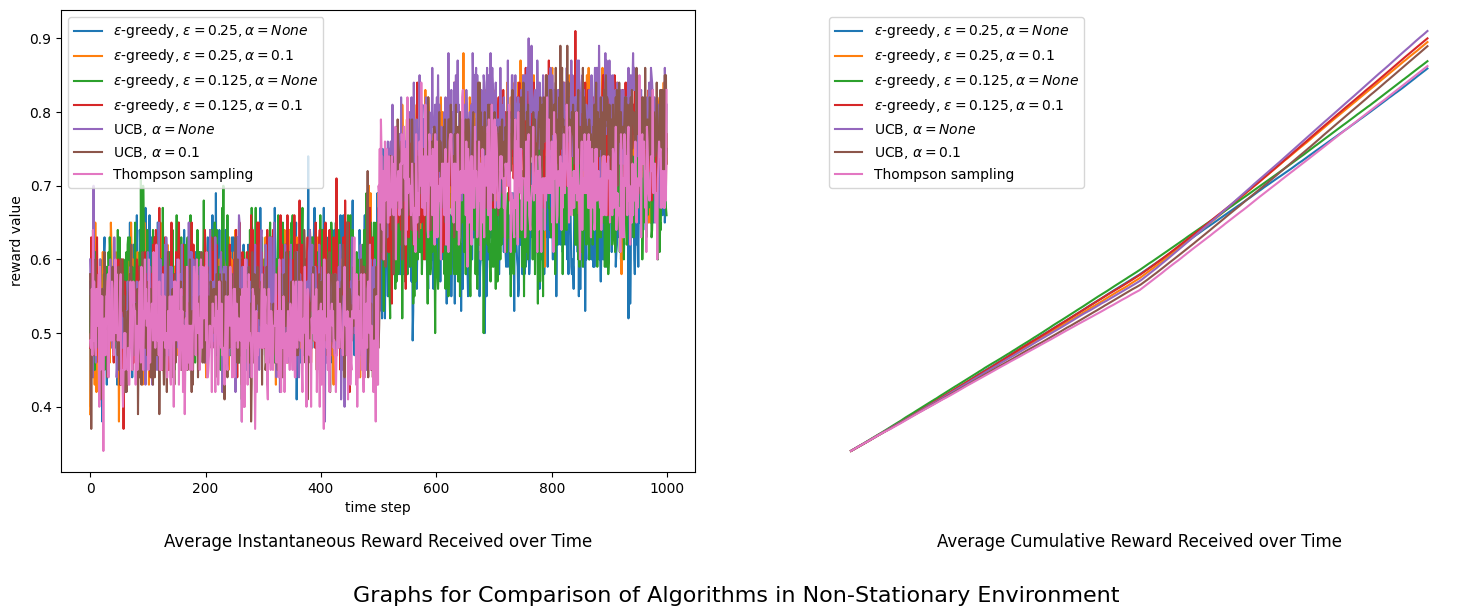

In [61]:
delta = 0.1
epsilon = [1/4, 1/8]
alpha = [None, 0.1]

def probs_fct (t):
    if t < 500:
        return [0.5+delta, 0.5, 0.5-delta]
    else:
        return [0.5+delta, 0.5+2*delta, 0.5+3*delta]
    
three_arm_bernoulli_bandit_non_stationary = BernoulliBandit(3, probs_fct)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))


# arrays of the data generated from 100 runs
R_over_t_runs = []
total_R_over_t_runs = []
est_is_best_over_t_runs = []
l_over_t_runs = []
total_l_over_t_runs = []

for run in range(100):
    R_over_t_eps0_a0, total_R_over_t_eps0_a0, _, _, _ = epsilon_greedy(three_arm_bernoulli_bandit_non_stationary, epsilon=epsilon[0], alpha=alpha[0])
    R_over_t_eps0_a1, total_R_over_t_eps0_a1, _, _, _ = epsilon_greedy(three_arm_bernoulli_bandit_non_stationary, epsilon=epsilon[0], alpha=alpha[1])
    R_over_t_eps1_a0, total_R_over_t_eps1_a0, _, _, _ = epsilon_greedy(three_arm_bernoulli_bandit_non_stationary, epsilon=epsilon[1], alpha=alpha[0])
    R_over_t_eps1_a1, total_R_over_t_eps1_a1, _, _, _ = epsilon_greedy(three_arm_bernoulli_bandit_non_stationary, epsilon=epsilon[1], alpha=alpha[1])
    R_over_t_ucb_a0, total_R_over_t_ucb_a0, _, _, _ = UCB(three_arm_bernoulli_bandit_non_stationary, alpha=alpha[0])
    R_over_t_ucb_a1, total_R_over_t_ucb_a1, _, _, _ = UCB(three_arm_bernoulli_bandit_non_stationary, alpha=alpha[1])
    R_over_t_ts, total_R_over_t_ts, _, _, _ = Thompson_sampling(three_arm_bernoulli_bandit_non_stationary)
    
    R_over_t_runs.append([R_over_t_eps0_a0, R_over_t_eps0_a1, R_over_t_eps1_a0, R_over_t_eps1_a1, R_over_t_ucb_a0, R_over_t_ucb_a1, R_over_t_ts])
    total_R_over_t_runs.append([total_R_over_t_eps0_a0, total_R_over_t_eps0_a1, total_R_over_t_eps1_a0, total_R_over_t_eps1_a1, total_R_over_t_ucb_a0, total_R_over_t_ucb_a1, total_R_over_t_ts])
    
    
R_over_t_runs = np.asarray(R_over_t_runs)
total_R_over_t_runs = np.asarray(total_R_over_t_runs)
est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
l_over_t_runs = np.asarray(l_over_t_runs)
total_l_over_t_runs = np.asarray(total_l_over_t_runs)

# plot the mean reward over time
mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

axs[0].plot(mean_R_over_t_runs[0], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[0], alpha[0]))
axs[0].plot(mean_R_over_t_runs[1], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[0], alpha[1]))
axs[0].plot(mean_R_over_t_runs[2], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[1], alpha[0]))
axs[0].plot(mean_R_over_t_runs[3], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[1], alpha[1]))
axs[0].plot(mean_R_over_t_runs[4], label = r"UCB, $\alpha = %s$" %alpha[0])
axs[0].plot(mean_R_over_t_runs[5], label = r"UCB, $\alpha = %s$" %alpha[1])
axs[0].plot(mean_R_over_t_runs[6], label = r"Thompson sampling")

R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs

axs[0].legend()
axs[0].set_xlabel("time step")
axs[0].set_ylabel("reward value")
axs[0].set_title("Average Instantaneous Reward Received over Time", y=-0.18)

# plot the mean cumulative reward

mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

axs[1].plot(mean_total_R_over_t_runs[0], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[0], alpha[0]))
axs[1].plot(mean_total_R_over_t_runs[1], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[0], alpha[1]))
axs[1].plot(mean_total_R_over_t_runs[2], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[1], alpha[0]))
axs[1].plot(mean_total_R_over_t_runs[3], label = r"$\epsilon$-greedy, $\epsilon = %s, \alpha = %s$" %(epsilon[1], alpha[1]))
axs[1].plot(mean_total_R_over_t_runs[4], label = r"UCB, $\alpha = %s$" %alpha[0])
axs[1].plot(mean_total_R_over_t_runs[5], label = r"UCB, $\alpha = %s$" %alpha[1])
axs[1].plot(mean_total_R_over_t_runs[6], label = r"Thompson sampling")

total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs

axs[1].legend()
axs[1].set_xlabel("time step")
axs[1].set_ylabel("reward value")
axs[1].set_title("Average Cumulative Reward Received over Time", y=-0.18)

axs[-1].axis('off')

title = r'Graphs for Comparison of Algorithms in Non-Stationary Environment'
fig.suptitle(title, fontsize=16, y=-0.08)

plt.show()

### Answers